In [54]:
### Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [55]:
# Load in the data "
data = pd.read_csv('../multiple_regression/merged_data.csv')
data.rename(columns={'CPALWE01USQ661N': 'CPI', 'S&P 500 ^GSPC': 'S&P_500', 'NASDAQ ^IXIC': 'NASDAQ', 'Dow Jones ^DJI':'Dow_Jones', 'RealInterestRate':'Real_IR', 'UnemploymentRate': 'Unemployment_Rate', 'FedFundsRate': 'Federal_Funds_Rate'}, inplace = True)
dates = data['Date']
data

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
...,...,...,...,...,...,...,...,...,...,...
123,2022-10-01,3871.979980,10988.150391,32732.949219,126.044174,1.797332,3.6,3.4,21429.5,3.08
124,2023-01-01,4076.600098,11584.549805,34086.039062,127.208058,1.783099,3.5,2.8,21364.4,4.33
125,2023-04-01,4169.479980,12226.580078,34098.160156,128.770113,1.443914,3.4,2.4,20924.5,4.83
126,2023-07-01,4588.959961,14346.019531,35559.531250,129.949384,1.426047,3.5,4.4,20744.8,5.12


In [56]:
# differencing
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore')  

# using differencing = 1 ARIMA(0,1,0)
data['S&P_500_Diff'] = data['S&P_500'].diff()

data = data.dropna() #drops first row with NA values due to differencing
data

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate,S&P_500_Diff
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73,6.170013
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25,9.259979
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10,-5.529999
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02,20.100006
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96,1.410004
...,...,...,...,...,...,...,...,...,...,...,...
123,2022-10-01,3871.979980,10988.150391,32732.949219,126.044174,1.797332,3.6,3.4,21429.5,3.08,-258.310059
124,2023-01-01,4076.600098,11584.549805,34086.039062,127.208058,1.783099,3.5,2.8,21364.4,4.33,204.620117
125,2023-04-01,4169.479980,12226.580078,34098.160156,128.770113,1.443914,3.4,2.4,20924.5,4.83,92.879883
126,2023-07-01,4588.959961,14346.019531,35559.531250,129.949384,1.426047,3.5,4.4,20744.8,5.12,419.479980


In [57]:
# defining independent and dependent variables for lasso-ARIMAX
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate', 'S&P_500_Diff']
dependent_variable = ['S&P_500_Diff']

x = data[independent_variables].iloc[0:-1] #includes t-1
y = data[dependent_variable].iloc[1:] #includes t

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

dates = dates.iloc[y_test.index]

In [59]:
# Transform x values into standard normal (mean = 0, std = 1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [60]:
# running lasso with 5 folds on training set
lasso = LassoCV(cv = 5, random_state = 42)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [61]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
mse = rmse ** 2
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 255.55
Optimal Lambda: 3.45
CPI: 0.00
Real_IR: -1.81
Unemployment_Rate: 5.91
GDP_Growth: 21.21
M2_Supply: 8.74
Federal_Funds_Rate: 0.00
S&P_500_Diff: 0.27


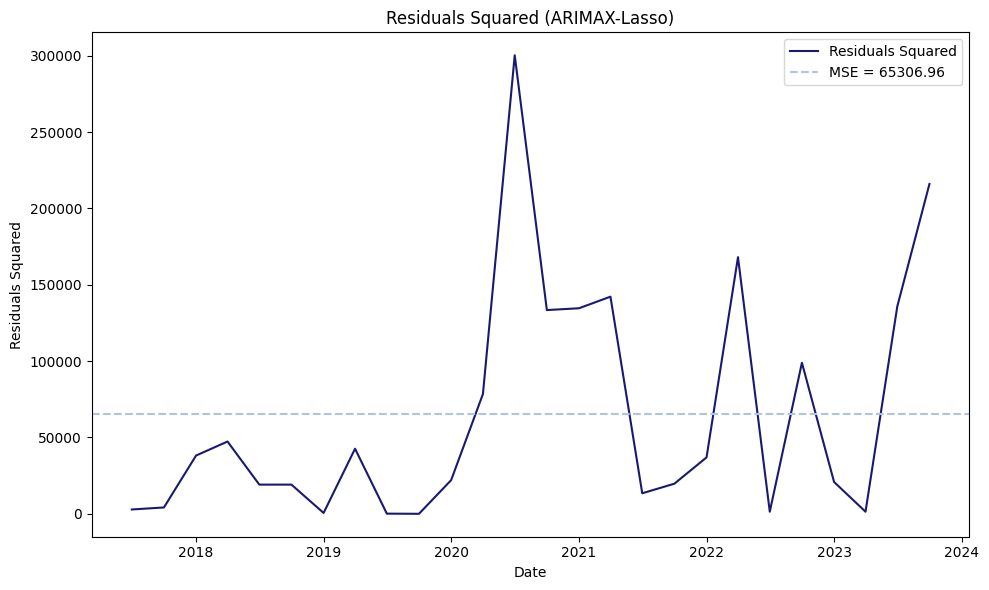

In [53]:
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(dates), residuals_squared, color = 'midnightblue', label = 'Residuals Squared')
plt.axhline(y = rmse**2, color = 'lightsteelblue', linestyle = '--', label = f'MSE = {rmse**2:.2f}')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared (ARIMAX-Lasso)')
plt.legend()
plt.tight_layout()
plt.show()

```bash
In this Time-Series Lasso model, we predicted the change in S&P 500 at time t using macroeconomic variables and the previous quarter’s change in S&P 500 (t−1). We constructed this structure by differencing the S&P 500 to ensure stationarity and shifting the data so that all predictor variables at time t−1 align with outcomes at time t.

The model yielded a Test RMSE of 255.55, showing it can moderately predict quarter-over-quarter movements in the index.

Coefficient Interpretation:
S&P_500_Diff (t−1) = 0.27: Indicates positive momentum — if the index increased last quarter, it is somewhat likely to rise again this quarter, but relatively week. 

GDP_Growth = 21.21: Strongest positive macroeconomic predictor; past GDP growth is closely tied to market gains.

M2_Supply = 8.74: Suggests that increased liquidity in the prior quarter contributes to upward movement in the market.

Unemployment_Rate = 5.91: Mildly positive, which may reflect lagged economic recoveries where job markets tighten after markets begin rising.

Real_IR = −1.81: Slight negative effect, consistent with theory that higher interest rates deter investment.

CPI and Federal_Funds_Rate = 0.00: Regularization pushed these to zero, meaning they were not helpful for predicting market movement when controlling for others.
```

In [65]:
data = {
    'Model': ['MLR (full-model)', 'Standard Lasso', 'ARIMAX-style Lasso'],
    'Test RMSE': [717.80, 738.24, 255.55],
    'Optimal Lambda': ['N/A', 1.50, 3.4],
    'Top Predictors': [
        'M2_Supply, Unemployment_Rate, GDP_Growth',
        'M2_Supply, Unemployment_Rate, CPI',
        'M2_Supply, GDP_Growth, Unemployment_Rate'
    ],
    'Differenced Series': ['No', 'No', 'Yes']
}

comparison_df = pd.DataFrame(data)

comparison_df

,Model,Test RMSE,Optimal Lambda,Top Predictors,Differenced Series
0,MLR (full-model),717.80,N/A,"M2_Supply, Unemployment_Rate, GDP_Growth",No
1,Standard Lasso,738.24,1.5,"M2_Supply, Unemployment_Rate, CPI",No
2,ARIMAX-style Lasso,255.55,3.4,"M2_Supply, GDP_Growth, Unemployment_Rate",Yes
